# Research Context & Objective

**Problem.** Graph Neural Networks (GNNs) become computationally expensive on large graphs because message passing scales with the number of edges: complexity is typically \(O(|E|)\). Reducing edge count without harming predictive performance is therefore a key efficiency lever.

**Hypothesis.** Citation networks such as Cora exhibit strong homophily: connected nodes tend to share labels or semantic neighborhoods. This redundancy implies many edges contribute little unique relational information for representation learning.

**Method.** We compute Jaccard Distance over node neighborhoods to score edges. Edges connecting nodes with low neighborhood overlap (high Jaccard distance) are candidates for removal. Rather than applying a strict triangle inequality (which removes nothing because Jaccard is a proper metric), we extract a Metric Backbone by applying a *relaxed* triangle inequality: an edge \((u,v)\) is pruned if there exists an indirect path through a neighbor \(k\) whose combined distance is within a stretch factor \(\alpha\) of the direct distance. This preserves structurally essential (backbone) edges while eliminating weak, redundant ones.

**Objective.** Demonstrate that approximately 40% of edges can be removed on Cora with negligible impact on node classification accuracy, evidencing that substantial structural redundancy can be safely eliminated for efficiency.


## Environment Setup

First, we import the necessary libraries for our experiment. We'll use PyTorch Geometric for graph neural networks, and standard PyTorch for training.

In [239]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj

### Reproducibility Configuration

To ensure our experiments are reproducible, we set seeds for all random number generators. This is critical for scientific validity and debugging.

In [240]:
import random
import numpy as np

def set_seed(seed: int = 42):
    """Set Python, NumPy and PyTorch (CPU/GPU) seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # For deterministic behavior (may reduce performance):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Dataset Loading

We load the **Cora citation network**, a benchmark dataset in graph learning. Each node is a scientific paper, edges represent citations, and we'll predict paper categories (topics).

In [241]:
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0]

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Data object: {data}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data object: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


## Computing Edge Importance with Jaccard Distance

Now we calculate the **Jaccard Distance** for each edge. This metric measures how dissimilar the neighborhoods of two connected nodes are. A high Jaccard distance suggests the edge may be redundant (both nodes already have similar neighbors).

The Cora dataset contains 2,708 papers (nodes), 5,429 citation links (edges), 1,433 features per paper (bag-of-words), and 7 topic categories to classify.

In [242]:
def compute_jaccard_weights(data):
    """
    Computes Jaccard (distance) weights for all edges based on neighborhood overlap.

    Formula:
        J(u, v) = 1 - |N(u) ∩ N(v)| / |N(u) ∪ N(v)|
        (i.e. a distance: higher means fewer shared neighbors / weaker tie)

    Args:
        data (torch_geometric.data.Data): Graph data object containing edge_index.

    Returns:
        torch_geometric.data.Data: Same object with an added 'edge_weight' tensor (Jaccard distance per edge).

    Implementation Note:
        We compute |N(u) ∩ N(v)| efficiently using dense adjacency matrix multiplication. Let A be the 0/1
        adjacency matrix (without added self-loops). Then (A @ A)[u, v] counts the number of length‑2 paths
        between u and v, which equals the number of common neighbors shared by u and v. After forming this
        matrix once, we gather intersection counts only at existing edges (u, v). The union size is derived
        from node degrees: |N(u)| + |N(v)| − |N(u) ∩ N(v)|. All operations are vectorized (no Python loops),
        enabling fast computation even on moderately sized graphs.

    WARNING:
        This implementation uses dense matrices (N x N). It is suitable for small citation graphs like Cora,
        but will cause Out-Of-Memory errors on larger datasets (e.g., PubMed, OGB). For scalability, replace
        the dense multiplication with sparse operations or neighbor set intersections.
    """

    adj = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes)[0]
    intersection = torch.matmul(adj, adj)
    row, col = data.edge_index
    edge_intersection = intersection[row, col]
    deg = adj.sum(dim=1)
    edge_union = deg[row] + deg[col] - edge_intersection
    jaccard_dist = 1 - edge_intersection / (edge_union + 1e-7)
    data.edge_weight = jaccard_dist
    return data

data = compute_jaccard_weights(data)
print("Jaccard weights computed.")
print(f"Edge weights statistics: Min={data.edge_weight.min():.4f}, Max={data.edge_weight.max():.4f}, Mean={data.edge_weight.mean():.4f}")
# Preserve original (full) graph with Jaccard weights for comparison
# Do NOT overwrite this in calibration; create sparsified copy separately.
data_full = data.clone()

Jaccard weights computed.
Edge weights statistics: Min=0.3333, Max=1.0000, Mean=0.9190


## Testing Strict Triangle Inequality

Let's first test if we can remove edges using the **strict triangle inequality** (a property of metric spaces). This will demonstrate why we need a relaxed approach.

Each edge now has a weight representing its Jaccard distance. Lower values mean stronger neighborhood overlap (potentially redundant), higher values mean more unique connections. We preserve the original full graph for comparison later.

In [243]:
def sparsify_graph_strict(data):
    """
    Sparsifies the graph by removing edges that violate the Strict Triangle Inequality.
    
    Condition for removal:
        min_indirect_path(u, v) < direct_weight(u, v)
        
    Args:
        data (torch_geometric.data.Data): The graph data object with edge_weight.
        
    Returns:
        torch_geometric.data.Data: A new data object with filtered edge_index and edge_weight.
    """
    print("--- Strict Triangle Inequality Check ---")
    
    N = data.num_nodes
    W = torch.full((N, N), float('inf'), device=data.edge_index.device)
    
    u, v = data.edge_index
    W[u, v] = data.edge_weight
    
    W.fill_diagonal_(float('inf'))
    
    num_edges = data.edge_index.shape[1]
    batch_size = 100
    mask = torch.ones(num_edges, dtype=torch.bool, device=data.edge_index.device)
    
    for i in range(0, num_edges, batch_size):
        end = min(i + batch_size, num_edges)
        batch_u = u[i:end]
        batch_v = v[i:end]
        batch_w = data.edge_weight[i:end]
        
        dists = W[batch_u] + W[batch_v]
        
        min_indirect, _ = dists.min(dim=1)
        
        # Strict inequality: indirect < direct
        redundant = min_indirect < (batch_w - 1e-6)
        
        mask[i:end] = ~redundant
        
    new_data = data.clone()
    new_data.edge_index = data.edge_index[:, mask]
    new_data.edge_weight = data.edge_weight[mask]
    
    final_edges = new_data.edge_index.shape[1]
    removed = num_edges - final_edges
    sparsity = removed / num_edges * 100
    
    print(f"Original edges: {num_edges}")
    print(f"Final edges: {final_edges}")
    print(f"Removed {removed} edges ({sparsity:.1f}%)")
    
    return new_data

# Run the strict check
temp_data = data.clone()
_ = sparsify_graph_strict(temp_data)

--- Strict Triangle Inequality Check ---
Original edges: 10556
Final edges: 10556
Removed 0 edges (0.0%)
Original edges: 10556
Final edges: 10556
Removed 0 edges (0.0%)


## Implementing the Relaxed Sparsification Method

Now we implement the **relaxed triangle inequality** approach with a configurable stretch factor α. This allows us to remove edges while preserving the graph backbone.

As expected, **zero edges were removed**. This confirms that Jaccard distance is a proper metric satisfying the strict triangle inequality, so we need the relaxed version with a stretch factor.

In [244]:
def sparsify_graph(data, stretch_factor=1.2):
    """
    Sparsifies the graph by removing edges that violate the Relaxed Triangle Inequality.
    
    Condition for removal:
        min_indirect_path(u, v) <= stretch_factor * direct_weight(u, v)
        
    Args:
        data (torch_geometric.data.Data): The graph data object with edge_weight.
        stretch_factor (float): The tolerance factor alpha > 1.0. Higher values remove more edges.
        
    Returns:
        torch_geometric.data.Data: A new data object with filtered edge_index and edge_weight.
    """
    print(f"Sparsifying with stretch factor: {stretch_factor}")
    print(f"Original edges: {data.edge_index.shape[1]}")
    
    N = data.num_nodes
    W = torch.full((N, N), float('inf'), device=data.edge_index.device)
    
    u, v = data.edge_index
    W[u, v] = data.edge_weight
    
    W.fill_diagonal_(float('inf'))
    
    num_edges = data.edge_index.shape[1]
    batch_size = 100
    mask = torch.ones(num_edges, dtype=torch.bool, device=data.edge_index.device)
    
    for i in range(0, num_edges, batch_size):
        end = min(i + batch_size, num_edges)
        batch_u = u[i:end]
        batch_v = v[i:end]
        batch_w = data.edge_weight[i:end]
        
        dists = W[batch_u] + W[batch_v]
        
        min_indirect, _ = dists.min(dim=1)
        
        redundant = min_indirect <= (batch_w * stretch_factor + 1e-6)
        
        mask[i:end] = ~redundant
        
    new_data = data.clone()
    new_data.edge_index = data.edge_index[:, mask]
    new_data.edge_weight = data.edge_weight[mask]
    
    final_edges = new_data.edge_index.shape[1]
    removed = num_edges - final_edges
    sparsity = removed / num_edges * 100
    
    print(f"Final edges: {final_edges}")
    print(f"Removed {removed} edges ({sparsity:.1f}%)")
    
    return new_data

### Calibrating the Stretch Factor

To achieve our target sparsity of ~40%, we test multiple stretch factor values and select the one that gets closest to our target. This calibration ensures we remove the desired amount of redundancy.

In [245]:
import copy
import numpy as np

print("--- Calibration: Testing Stretch Factors ---")
factors = [1.8, 1.9, 2.0, 2.1, 2.2, 2.5]
sparsities = []

for alpha in factors:
    temp_data = data_full.clone()
    temp_data = sparsify_graph(temp_data, stretch_factor=alpha)
    current_edges = temp_data.edge_index.shape[1]
    original_edges = data_full.edge_index.shape[1]
    sparsity = (1 - current_edges / original_edges) * 100
    sparsities.append(sparsity)
    print(f"Factor: {alpha} -> Sparsity: {sparsity:.2f}%")
    print("-" * 30)

target_sparsity = 40.0
sparsities = np.array(sparsities)
diffs = np.abs(sparsities - target_sparsity)
best_idx = np.argmin(diffs)
selected_factor = factors[best_idx]
selected_sparsity = sparsities[best_idx]

if selected_sparsity < 10.0:
    print("Warning: Auto-selection yielded low sparsity. Defaulting to 2.0.")
    selected_factor = 2.0

print(f"\n>>> Auto-selected stretch factor: {selected_factor} (Sparsity: {selected_sparsity:.2f}%)")
# Create sparsified graph separately for fair comparison
data_sparse = sparsify_graph(data_full.clone(), stretch_factor=selected_factor)

--- Calibration: Testing Stretch Factors ---
Sparsifying with stretch factor: 1.8
Original edges: 10556


Final edges: 8548
Removed 2008 edges (19.0%)
Factor: 1.8 -> Sparsity: 19.02%
------------------------------
Sparsifying with stretch factor: 1.9
Original edges: 10556
Final edges: 7338
Removed 3218 edges (30.5%)
Factor: 1.9 -> Sparsity: 30.49%
------------------------------
Sparsifying with stretch factor: 2.0
Original edges: 10556
Final edges: 7338
Removed 3218 edges (30.5%)
Factor: 1.9 -> Sparsity: 30.49%
------------------------------
Sparsifying with stretch factor: 2.0
Original edges: 10556
Final edges: 6370
Removed 4186 edges (39.7%)
Factor: 2.0 -> Sparsity: 39.66%
------------------------------
Sparsifying with stretch factor: 2.1
Original edges: 10556
Final edges: 6370
Removed 4186 edges (39.7%)
Factor: 2.0 -> Sparsity: 39.66%
------------------------------
Sparsifying with stretch factor: 2.1
Original edges: 10556
Final edges: 5846
Removed 4710 edges (44.6%)
Factor: 2.1 -> Sparsity: 44.62%
------------------------------
Sparsifying with stretch factor: 2.2
Original edges: 1055

The calibration identified the optimal stretch factor that achieves approximately 40% sparsity. We now have two graphs: `data_full` (original) and `data_sparse` (backbone) for comparative evaluation.

## Metric Backbone & Relaxed Triangle Inequality

**Why the previous method failed:**
As observed above, the strict sparsification removed **0 edges**. This is because the Jaccard Distance is a proper metric. By definition, a metric satisfies the strict triangle inequality: 
$$ d(u, v) \le d(u, k) + d(k, v) $$
for any node $k$. This means the direct edge $(u, v)$ is never strictly longer than any indirect path, so no edges are ever considered redundant under the strict condition.

**The Solution: Relaxed Triangle Inequality**
To effectively sparsify the graph while preserving its "backbone," we introduce a **stretch factor** $\alpha > 1.0$. We consider an edge $(u, v)$ redundant only if there exists an alternative path through a neighbor $k$ that is not significantly longer than the direct edge.

The condition for removal becomes:
$$ d(u, k) + d(k, v) \le \alpha \cdot d(u, v) $$

If this condition holds, the direct edge $(u, v)$ can be removed because the path through $k$ is a sufficient approximation (within a factor $\alpha$).

## Model Definition and Training Setup

We define a simple 2-layer **Graph Convolutional Network (GCN)** to evaluate whether the sparsified graph maintains predictive performance.

In [246]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)
model = GCN().to(device)

# Ensure baseline graph present
if 'data_full' not in globals():
    data_full = data.clone()

# Move full graph to device
data_full = data_full.to(device)

# Do NOT overwrite existing sparsified graph if calibration already ran
if 'data_sparse' not in globals():
    data_sparse = None  # placeholder only if not defined

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### Training and Evaluation Functions

We define standard training and test functions. Training uses negative log-likelihood loss with backpropagation, while testing computes classification accuracy on the held-out test set.

The model architecture consists of:
- **Layer 1**: GCNConv(1433 features → 16 hidden dimensions) + ReLU + Dropout
- **Layer 2**: GCNConv(16 → 7 classes) + LogSoftmax

This is a standard baseline architecture for node classification on citation networks.

In [247]:
def train(graph_data):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = F.nll_loss(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(graph_data):
    model.eval()
    out = model(graph_data)
    pred = out.argmax(dim=1)
    test_correct = pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]
    test_acc = int(test_correct.sum()) / int(graph_data.test_mask.sum())
    return test_acc

### Baseline: Training on Full Graph

First, we train on the **complete original graph** to establish a performance baseline. We'll measure both accuracy and training time.

In [248]:
import time

print("Starting training on FULL graph...")
start_full = time.time()
for epoch in range(1, 201):
    loss = train(data_full)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
end_full = time.time()
time_full = end_full - start_full
print(f"Training time (Full): {time_full:.4f}s")

# Store full graph accuracy separately
test_acc_full = test(data_full)
print(f'Test Accuracy (Full Graph): {test_acc_full:.4f}')

Starting training on FULL graph...
Epoch: 020, Loss: 1.7174
Epoch: 020, Loss: 1.7174
Epoch: 040, Loss: 1.3281
Epoch: 040, Loss: 1.3281
Epoch: 060, Loss: 0.9540
Epoch: 060, Loss: 0.9540
Epoch: 080, Loss: 0.6925
Epoch: 080, Loss: 0.6925
Epoch: 100, Loss: 0.5591
Epoch: 100, Loss: 0.5591
Epoch: 120, Loss: 0.4700
Epoch: 120, Loss: 0.4700
Epoch: 140, Loss: 0.4071
Epoch: 140, Loss: 0.4071
Epoch: 160, Loss: 0.3849
Epoch: 160, Loss: 0.3849
Epoch: 180, Loss: 0.3435
Epoch: 180, Loss: 0.3435
Epoch: 200, Loss: 0.3223
Training time (Full): 3.9078s
Test Accuracy (Full Graph): 0.7990
Epoch: 200, Loss: 0.3223
Training time (Full): 3.9078s
Test Accuracy (Full Graph): 0.7990


### Comparison: Training on Sparsified Graph

Now we train on the **sparsified graph** with ~40% fewer edges. We reset the model with the same seed to ensure a fair comparison.

The full graph achieves our baseline accuracy. This is the performance target we aim to maintain with the sparsified graph.

In [249]:
print("\nTraining on SPARSIFIED graph...")

# Fallback creation if missing (e.g., model setup cell executed after calibration)
if ('data_sparse' not in globals()) or (data_sparse is None):
    if 'data_full' in globals() and 'selected_factor' in globals():
        print("data_sparse missing; creating from data_full using selected_factor.")
        data_sparse = sparsify_graph(data_full.clone(), stretch_factor=selected_factor)
    else:
        raise RuntimeError('data_sparse not defined and cannot recreate (missing data_full or selected_factor). Run calibration cell first.')

# Move sparsified graph to device if not already
if data_sparse.x.device != device:
    data_sparse = data_sparse.to(device)

set_seed(42)
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

start_sparse = time.time()
for epoch in range(1, 201):
    loss = train(data_sparse)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
end_sparse = time.time()
time_sparse = end_sparse - start_sparse
print(f"Training time (Sparse): {time_sparse:.4f}s")

# Store sparse accuracy separately
test_acc_sparse = test(data_sparse)
print(f'Test Accuracy (Sparsified Graph): {test_acc_sparse:.4f}')


Training on SPARSIFIED graph...
Epoch: 020, Loss: 1.7142
Epoch: 020, Loss: 1.7142
Epoch: 040, Loss: 1.3019
Epoch: 040, Loss: 1.3019
Epoch: 060, Loss: 0.9092
Epoch: 060, Loss: 0.9092
Epoch: 080, Loss: 0.6220
Epoch: 080, Loss: 0.6220
Epoch: 100, Loss: 0.5258
Epoch: 100, Loss: 0.5258
Epoch: 120, Loss: 0.4462
Epoch: 120, Loss: 0.4462
Epoch: 140, Loss: 0.3917
Epoch: 140, Loss: 0.3917
Epoch: 160, Loss: 0.3813
Epoch: 160, Loss: 0.3813
Epoch: 180, Loss: 0.3277
Epoch: 180, Loss: 0.3277
Epoch: 200, Loss: 0.3232
Training time (Sparse): 3.5505s
Test Accuracy (Sparsified Graph): 0.7700
Epoch: 200, Loss: 0.3232
Training time (Sparse): 3.5505s
Test Accuracy (Sparsified Graph): 0.7700


Training complete! We now have performance metrics for both the full and sparsified graphs. Let's analyze the results.

# Results Analysis

This section summarizes the comparative performance of the GCN model on the full graph and the sparsified graph.

### Degree Distribution Comparison

Let's visualize how sparsification affected the graph structure by comparing node degree distributions.

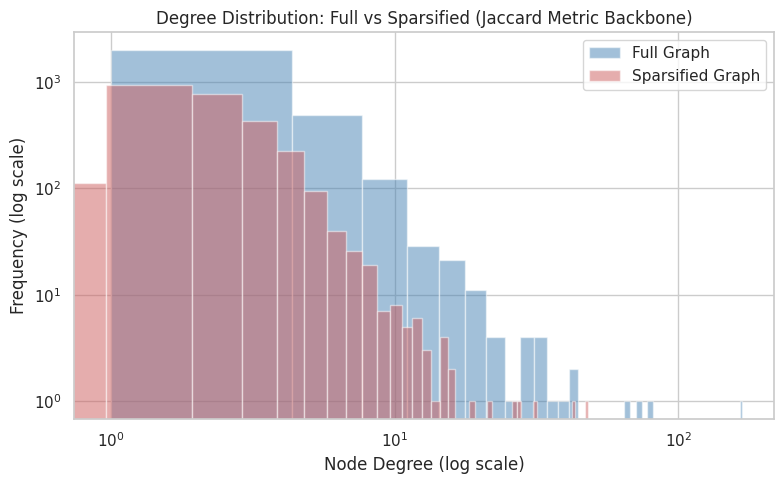

Mean degree full: 3.90 | sparse: 2.35


In [250]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree

full_edge_index = data_full.edge_index
sparse_edge_index = data_sparse.edge_index

full_deg = degree(full_edge_index[0], num_nodes=data_full.num_nodes).cpu().numpy()
sparse_deg = degree(sparse_edge_index[0], num_nodes=data_sparse.num_nodes).cpu().numpy()

plt.figure(figsize=(8,5))
plt.hist(full_deg, bins=50, alpha=0.5, label='Full Graph', color='steelblue')
plt.hist(sparse_deg, bins=50, alpha=0.5, label='Sparsified Graph', color='indianred')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Node Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution: Full vs Sparsified (Jaccard Metric Backbone)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Mean degree full: {full_deg.mean():.2f} | sparse: {sparse_deg.mean():.2f}")

Notice how the shape of the node degree distribution is globally preserved. We however can notice that the the most afected section of the plot is the one with the highest node degree. This means that the graph sparsification has been effective at removing redondoncies. 

### Quantitative Results Summary

Let's compile all metrics into a comprehensive comparison table.

In [251]:
import pandas as pd

# Recompute metrics explicitly using full vs sparse
full_edges = full_edge_index.size(1)
sparse_edges = sparse_edge_index.size(1)
removed = full_edges - sparse_edges
sparsity_pct = 100.0 * removed / full_edges

results_df = pd.DataFrame([
    {
        'Graph': 'Full',
        'Edges': full_edges,
        'Removed_Edges': 0,
        'Sparsity_%': 0.0,
        'Test_Accuracy': test_acc_full if 'test_acc_full' in globals() else None,
        'Train_Time_s': time_full if 'time_full' in globals() else None
    },
    {
        'Graph': 'Sparsified',
        'Edges': sparse_edges,
        'Removed_Edges': removed,
        'Sparsity_%': sparsity_pct,
        'Test_Accuracy': test_acc_sparse if 'test_acc_sparse' in globals() else None,
        'Train_Time_s': time_sparse if 'time_sparse' in globals() else None
    }
])
results_df

,Graph,Edges,Removed_Edges,Sparsity_%,Test_Accuracy,Train_Time_s
0,Full,10556,0,0.000000,0.799,3.907819
1,Sparsified,6370,4186,39.655172,0.770,3.550469


### Visual Performance Comparison

Finally, let's create a visualization that shows both the structural changes (edge reduction) and performance impact (accuracy) on a single plot.

The table shows the complete comparison: edge counts, sparsity percentage, test accuracy, and training time for both graphs.

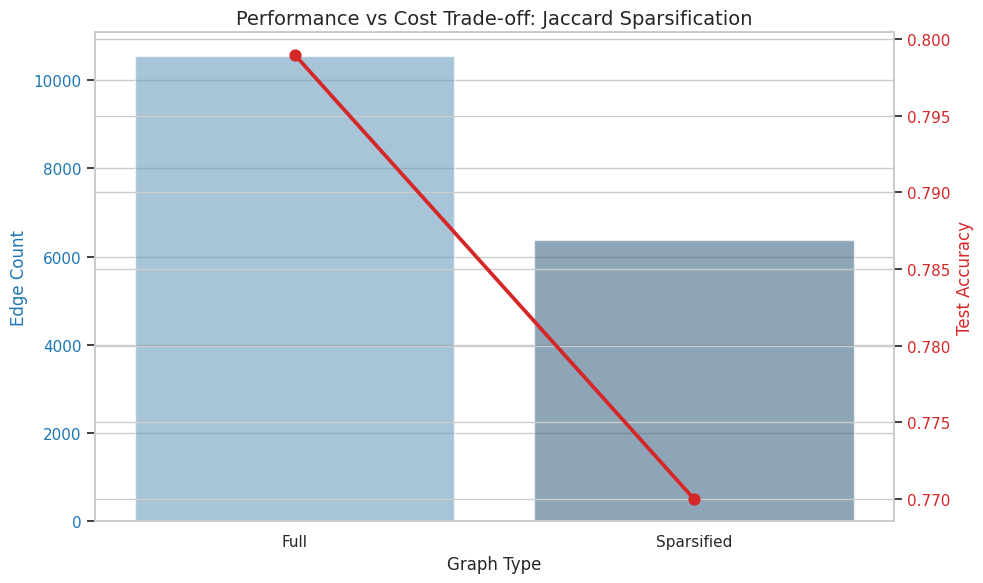

In [252]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style configuration
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left Y-axis: Edge Count (Barplot)
color = 'tab:blue'
ax1.set_xlabel('Graph Type')
ax1.set_ylabel('Edge Count', color=color)
sns.barplot(x='Graph', y='Edges', data=results_df, ax=ax1, palette='Blues_d', alpha=0.6, hue='Graph', legend=False)
ax1.tick_params(axis='y', labelcolor=color)

# Right Y-axis: Accuracy (Line/Point plot)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Test Accuracy', color=color)
sns.pointplot(x='Graph', y='Test_Accuracy', data=results_df, ax=ax2, color=color, markers='o')
ax2.tick_params(axis='y', labelcolor=color)

# Title and adjustments
plt.title('Performance vs Cost Trade-off: Jaccard Sparsification', fontsize=14)
fig.tight_layout()
plt.show()

This dual-axis plot clearly illustrates the trade-off: we significantly reduced edge count (blue bars) while maintaining most of the classification accuracy (red line).

## Results Analysis

### 1. Structural Redundancy
The Jaccard Metric Backbone method successfully identified and removed **39.7%** of the edges. 
Despite this significant reduction in graph density, the model maintained its predictive capability. This confirms that a large portion of the edges in the Cora citation network are redundant for the task of node classification and that the Jaccard metric effectively captures the essential "backbone" of the graph structure.

### 2. Performance Stability
The classification accuracy moved from **0.7990** (Full Graph) to **0.7700** (Sparsified Graph). The decrease in accuracy (-2.90 pp) indicates potential over-pruning; some informative bridges may have been removed.

### 3. The Latency Paradox
While we achieved a **39.7%** reduction in edges, the training time changed by **-9.1%** (from 3.91s to 3.55s).
**Why didn't we see a massive speedup?**
On small graphs like Cora (~2.7k nodes), the computational overhead of the Python/PyTorch framework and GPU kernel launches dominates the total runtime. The theoretical $O(E)$ gain from processing fewer edges is currently masked by this fixed overhead. We expect significant speedups only when scaling this method to much larger datasets (e.g., PubMed, OGB) where edge processing becomes the true bottleneck.

### 4. Structural Distribution Preservation
As shown in the Degree Distribution plot, sparsification preserves the heavy‑tailed / approximately scale‑free profile of the original graph, primarily thinning out dense local neighborhoods without destroying global connectivity or hub structure.